<a href="https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/main/examples/ssrVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-supervised VAE for data with orientational disorder


---

This notebook demonstrates how to use a variational autoencoder (VAE) to generalize from a small subset of labeled data with the weak orientational disorder to a large unlabelled data set with a much stronger orientational disorder.

---



Prepared by Maxim Ziatdinov

E-mail: ziatdinovmax@gmail.com

In [ ]:
#@title Installations
!pip install -q pyroved kornia

In [2]:
#@title Imports
import pyroved as pv

import kornia as K
import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import torch.tensor as tt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#@title Helper function
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    !gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
    !unzip -o -qq cards.zip
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


def transform_images(*args, **kwargs):
    card1, card2, card3, card4 = args
    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = kwargs.get("shear")
    z = kwargs.get("scale")
    n_samples = kwargs.get("samples", 3000)
    torch.manual_seed(kwargs.get("seed", 0))
    # Define transform(s)
    transform = nn.Sequential(
        K.augmentation.CenterCrop((48, 48)),
        K.augmentation.RandomAffine(a, translate=t, shear=[-s, s, -s, s], scale=z, p=1),
    )
    # Apply random transformations to a batch of 3000 images for each card type
    cards1 = transform(card1[None, None].repeat_interleave(n_samples, dim=0))
    cards2 = transform(card2[None, None].repeat_interleave(n_samples, dim=0))
    cards3 = transform(card3[None, None].repeat_interleave(n_samples, dim=0))
    cards4 = transform(card4[None, None].repeat_interleave(n_samples, dim=0))

    # Concatenate (this is our training set)
    cards_all = torch.cat([cards1, cards2, cards3, cards4]).squeeze().float()
    labels_all = torch.cat([torch.zeros(n_samples), torch.ones(n_samples),
                           2*torch.ones(n_samples), 3*torch.ones(n_samples)])
    return cards_all.flatten(1), pv.utils.to_onehot(labels_all.long(), n=4)


def plot_manifolds(model):   
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

## Training data

We are going to make our own training data from playing card suits, with monochrome clubs, spades, diamonds, and hearts.  Using a digitized symbols from Word as a starting point, we apply a set of affine transforms including rotation, shear, translation, and scale to prepare our data sets. Note that we are going to apply different sets of distortions to labeled and unlabeled parts of our data.

In [4]:
cards = get_data()

In [5]:
# Labeled set (no transaltion, small rotations)
X_sup, y_sup = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=4, translation=None, 
    samples=200, seed=0)
# Unlabeled set (translation, large rotations)
X_unsup, _ = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1, 
    samples=3000, seed=1)
# Validation set (same as unlabeled, but using different seed)
X_val, y_val = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1, 
    samples=1000, seed=2)

Here's the supervised part of our training set:

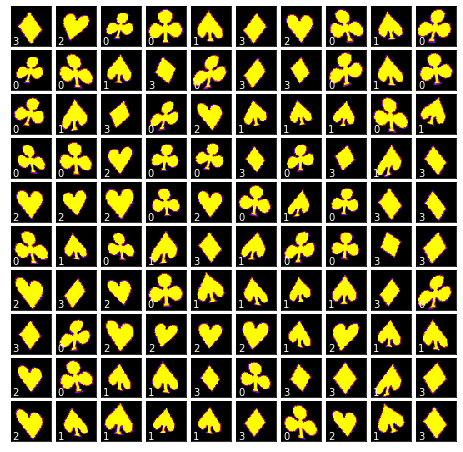

In [6]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_sup), size=(1,))
    im = X_sup[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_sup[i].argmax().item()),
            transform=ax.transAxes, color='white')

... and this is the unsupervised one. Note that here we have much larger orientational disorder as long as random offsets (in other words, the rotations and translations of the unlabeled data come from a different distribution than those of the labeled data!)

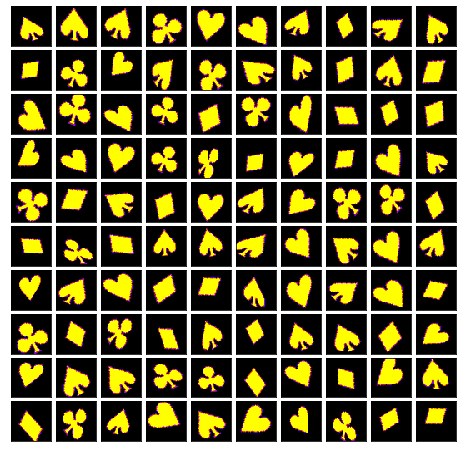

In [7]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_unsup), size=(1,))
    im = X_unsup[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')

Next, we create dataloaders:

In [8]:
(loader_unsup, loader_sup,
 loader_val) = pv.utils.init_ssvae_dataloaders(
     X_unsup, (X_sup, y_sup), (X_val, y_val), batch_size=64)

In [9]:
r = len(loader_sup) / (len(loader_unsup) + len(loader_sup))
print("Ratio of labeled data: {}".format(r))

Ratio of labeled data: 0.06467661691542288


## Train ss-iVAE model

Finally, we will train a semi supervised (ss) iVAE model. The goal is to use a limited amount (~6%) of labeled data with small positional (orientation+translation) disorder to categorize large volumes of unlabeled data characterized by a (much) higher positional disorder. During the training, we are also going to enforce **t**ranslational and **r**otational invariance.

Epoch: 1 Training loss: 805.9736, Test accuracy: 0.3902
Epoch: 2 Training loss: 510.4647, Test accuracy: 0.4853
Epoch: 3 Training loss: 462.6484, Test accuracy: 0.5232
Epoch: 4 Training loss: 419.8185, Test accuracy: 0.6150
Epoch: 5 Training loss: 392.6219, Test accuracy: 0.6262
Epoch: 6 Training loss: 374.5018, Test accuracy: 0.6222
Epoch: 7 Training loss: 360.5650, Test accuracy: 0.6115
Epoch: 8 Training loss: 348.8588, Test accuracy: 0.6155
Epoch: 9 Training loss: 337.2996, Test accuracy: 0.6052
Epoch: 10 Training loss: 326.9901, Test accuracy: 0.6240


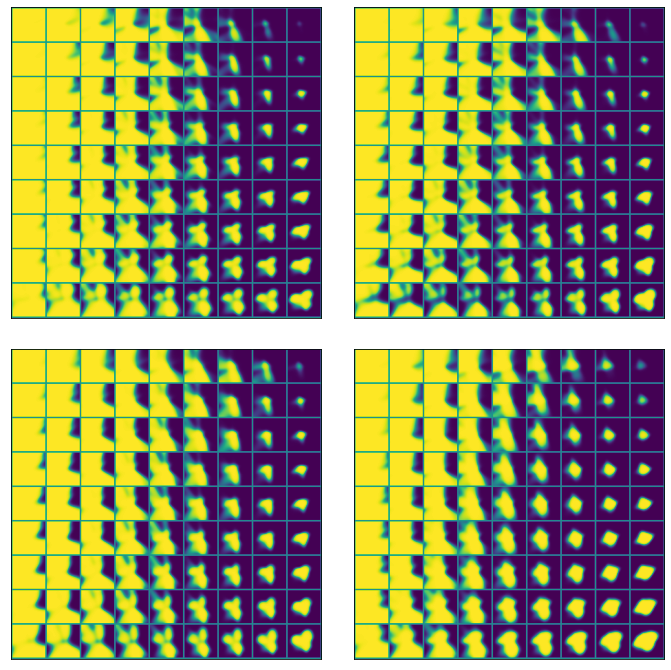

Epoch: 11 Training loss: 316.4895, Test accuracy: 0.6180
Epoch: 12 Training loss: 306.3293, Test accuracy: 0.6620
Epoch: 13 Training loss: 297.6148, Test accuracy: 0.6890
Epoch: 14 Training loss: 290.1692, Test accuracy: 0.7265
Epoch: 15 Training loss: 281.2962, Test accuracy: 0.7690
Epoch: 16 Training loss: 276.4297, Test accuracy: 0.7965
Epoch: 17 Training loss: 266.8697, Test accuracy: 0.8528
Epoch: 18 Training loss: 257.8195, Test accuracy: 0.8510
Epoch: 19 Training loss: 251.5100, Test accuracy: 0.8458
Epoch: 20 Training loss: 248.1459, Test accuracy: 0.8578


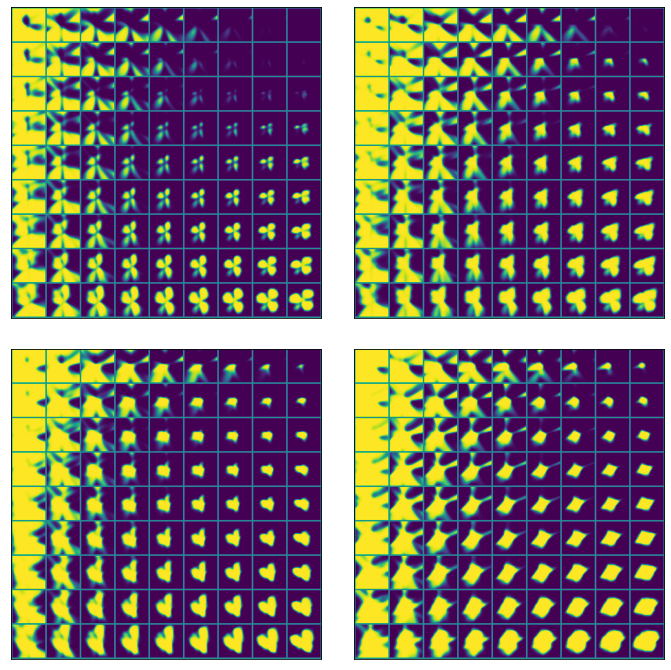

Epoch: 21 Training loss: 243.4918, Test accuracy: 0.8670
Epoch: 22 Training loss: 242.1165, Test accuracy: 0.8698
Epoch: 23 Training loss: 239.3134, Test accuracy: 0.8675
Epoch: 24 Training loss: 239.7460, Test accuracy: 0.8715
Epoch: 25 Training loss: 234.5616, Test accuracy: 0.8760
Epoch: 26 Training loss: 232.5668, Test accuracy: 0.8772
Epoch: 27 Training loss: 231.6656, Test accuracy: 0.8545
Epoch: 28 Training loss: 229.5909, Test accuracy: 0.8732
Epoch: 29 Training loss: 226.8812, Test accuracy: 0.8770
Epoch: 30 Training loss: 226.3119, Test accuracy: 0.8715


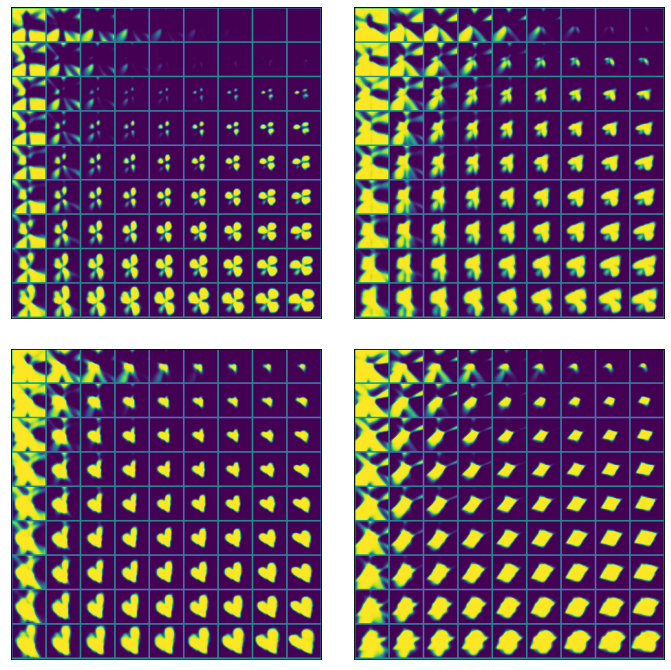

Epoch: 31 Training loss: 225.6362, Test accuracy: 0.8738
Epoch: 32 Training loss: 221.6694, Test accuracy: 0.8722
Epoch: 33 Training loss: 222.4169, Test accuracy: 0.8720
Epoch: 34 Training loss: 221.0070, Test accuracy: 0.8430
Epoch: 35 Training loss: 223.5961, Test accuracy: 0.8710
Epoch: 36 Training loss: 219.2805, Test accuracy: 0.8788
Epoch: 37 Training loss: 229.1641, Test accuracy: 0.8720
Epoch: 38 Training loss: 224.6846, Test accuracy: 0.8778
Epoch: 39 Training loss: 218.4125, Test accuracy: 0.8680
Epoch: 40 Training loss: 214.1295, Test accuracy: 0.8828


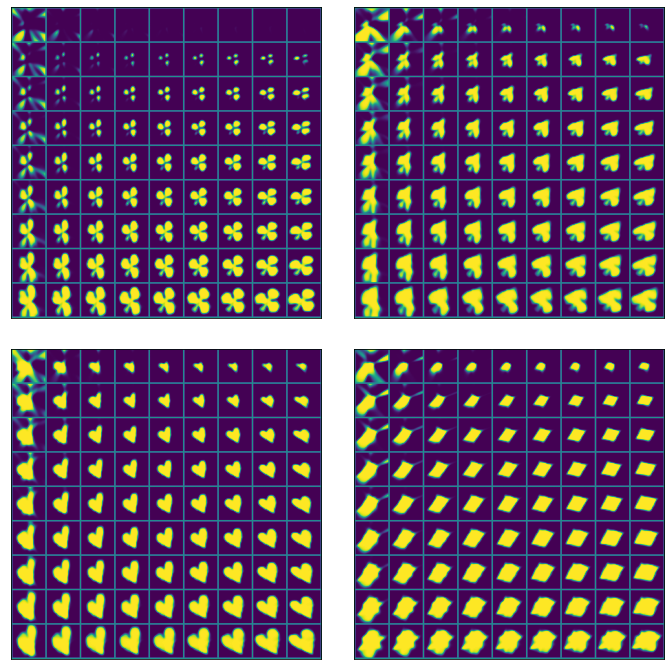

Epoch: 41 Training loss: 209.6477, Test accuracy: 0.8732
Epoch: 42 Training loss: 210.1157, Test accuracy: 0.8755
Epoch: 43 Training loss: 210.2856, Test accuracy: 0.8720
Epoch: 44 Training loss: 207.6124, Test accuracy: 0.8685
Epoch: 45 Training loss: 204.1297, Test accuracy: 0.8788
Epoch: 46 Training loss: 207.7363, Test accuracy: 0.8765
Epoch: 47 Training loss: 204.7439, Test accuracy: 0.8772
Epoch: 48 Training loss: 203.0997, Test accuracy: 0.8728
Epoch: 49 Training loss: 204.0993, Test accuracy: 0.8700
Epoch: 50 Training loss: 202.6081, Test accuracy: 0.8772


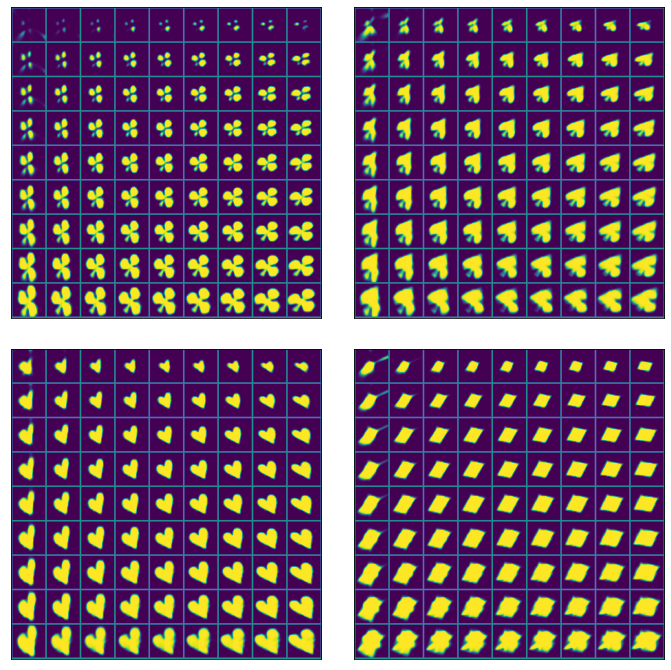

Epoch: 51 Training loss: 200.8764, Test accuracy: 0.8670
Epoch: 52 Training loss: 200.4368, Test accuracy: 0.8802
Epoch: 53 Training loss: 197.1437, Test accuracy: 0.8775
Epoch: 54 Training loss: 197.0005, Test accuracy: 0.8790
Epoch: 55 Training loss: 196.2671, Test accuracy: 0.8798
Epoch: 56 Training loss: 195.0143, Test accuracy: 0.8668
Epoch: 57 Training loss: 194.8309, Test accuracy: 0.8775
Epoch: 58 Training loss: 193.4137, Test accuracy: 0.8730
Epoch: 59 Training loss: 191.6726, Test accuracy: 0.8708
Epoch: 60 Training loss: 188.7219, Test accuracy: 0.8798


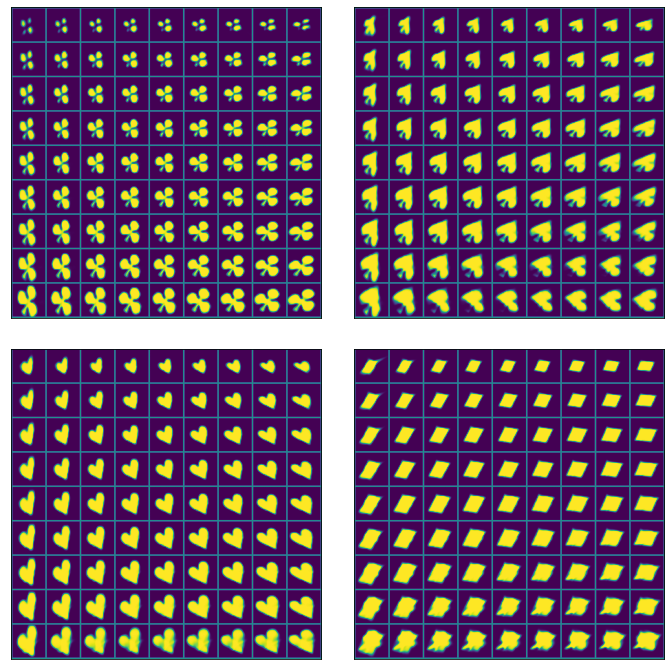

Epoch: 61 Training loss: 190.6797, Test accuracy: 0.8718
Epoch: 62 Training loss: 188.3436, Test accuracy: 0.8765
Epoch: 63 Training loss: 185.8938, Test accuracy: 0.8725
Epoch: 64 Training loss: 185.2185, Test accuracy: 0.8770
Epoch: 65 Training loss: 181.3000, Test accuracy: 0.8782
Epoch: 66 Training loss: 179.1547, Test accuracy: 0.8748
Epoch: 67 Training loss: 187.0873, Test accuracy: 0.8735
Epoch: 68 Training loss: 184.6066, Test accuracy: 0.8702
Epoch: 69 Training loss: 180.3921, Test accuracy: 0.8748
Epoch: 70 Training loss: 182.2926, Test accuracy: 0.8658


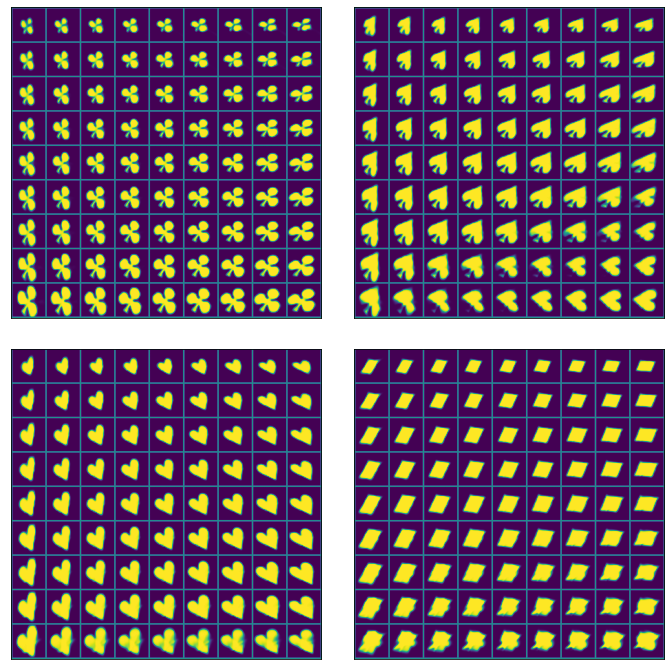

Epoch: 71 Training loss: 177.9651, Test accuracy: 0.8778
Epoch: 72 Training loss: 176.9065, Test accuracy: 0.8728
Epoch: 73 Training loss: 176.1555, Test accuracy: 0.8715
Epoch: 74 Training loss: 176.6516, Test accuracy: 0.8738
Epoch: 75 Training loss: 175.3861, Test accuracy: 0.8735
Epoch: 76 Training loss: 173.7453, Test accuracy: 0.8710
Epoch: 77 Training loss: 173.5920, Test accuracy: 0.8758
Epoch: 78 Training loss: 176.7559, Test accuracy: 0.8740
Epoch: 79 Training loss: 171.9505, Test accuracy: 0.8695
Epoch: 80 Training loss: 171.7032, Test accuracy: 0.8680


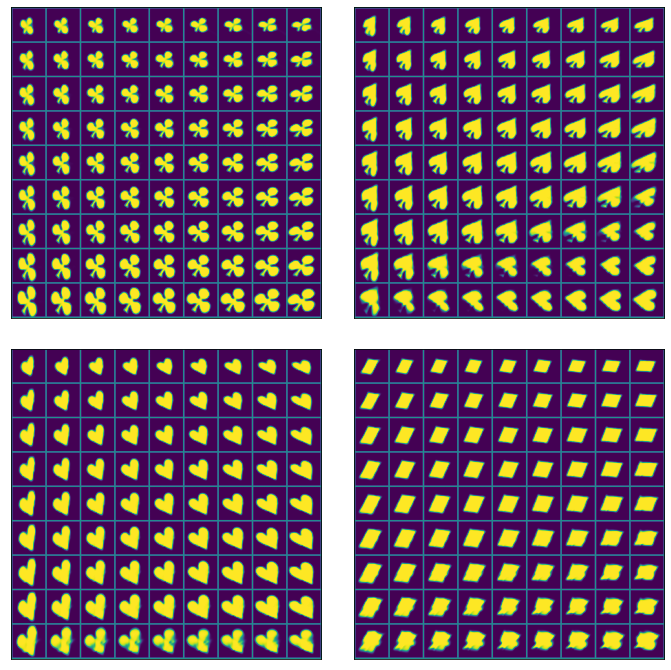

In [10]:
data_dim = (48, 48)
latent_dim = 2
num_classes = 4 

# Initialize model
ssvae = pv.models.ssiVAE(
    data_dim, latent_dim, num_classes, invariances=['r', 't'])

# Initialize trainer
trainer = pv.trainers.auxSVItrainer(ssvae)

# We're going to ramp-up KL weight from 1 to 2 in the first 30 epochs
kl_scale = torch.linspace(1, 2, 30)
# Train model for n epochs
for e in range(80):
    sc = kl_scale[e] if e < len(kl_scale) else kl_scale[-1]
    trainer.step(loader_unsup, loader_sup, loader_val,
                 aux_loss_multiplier=30, scale_factor=sc)
    trainer.print_statistics()
    # Plot learned altent manifolds every 10 epoch
    if (e+1) % 10 == 0:
        plot_manifolds(ssvae)

Looks like we achieved ~88% accuracy with only ~6% of the data labeled! Furthermore, we were able to disentangle two main factors of data variation (beyond rotations and translations), namely, scale and shear deformation, which are encoded in the first (top to bottom) and second (left to right) latent variables. 

We can also plot traversals of the learned manifold where the horizontal direction corresponds to one of the continuous latent variables (while the other one is fixed at 0) and the vertical direction corresponds to the categorical variable:

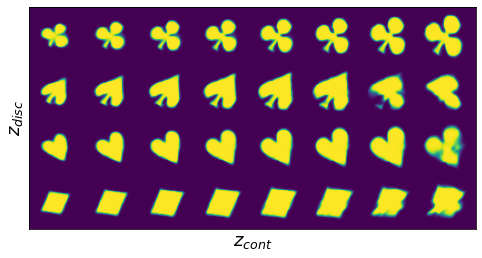

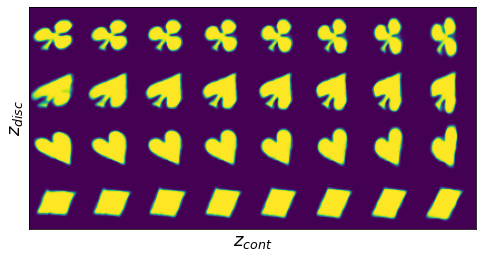

In [11]:
for i in range(2):
    ssvae.manifold_traversal(8, i, cmap='viridis')